In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Map Open Images URLs (single-turn or multi-turn) to local Open Images images.

Supports two input formats:
  1. Single-turn (e.g., preference.jsonl):
     {"open_image_input_url": "https://farm6.staticflickr.com/..._o.jpg", ...}

  2. Multi-turn (e.g., multi_turn.jsonl):
     {"files": [{"id": "original_input_image", "url": "https://farm6.staticflickr.com/..._o.jpg"}, ...]}
"""

import os
import csv
import json
from tqdm import tqdm

jsonl_in = "openimages/jsonl/sft.jsonl"
jsonl_out = "openimages/jsonl/sft_with_local_source_image_path.jsonl"
image_root = "openimages/source"       # 视你的解压目录而定
metadata_csv = "openimages/train-images-boxable-with-rotation.csv"

print("📘 Loading metadata mapping (URL → ImageID)...")
url_to_id = {}
with open(metadata_csv, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        url = row["OriginalURL"].strip()
        img_id = row["ImageID"].strip()
        url_to_id[url] = img_id
print(f"✅ Loaded {len(url_to_id):,} entries from metadata CSV")


print(f"📂 Indexing local .jpg images under {image_root}...")
local_id_to_path = {}
for root, _, files in tqdm(os.walk(image_root), desc="Scanning subfolders"):
    for file in files:
        if file.lower().endswith(".jpg"):
            image_id = os.path.splitext(file)[0]
            local_id_to_path[image_id] = os.path.join(root, file)
print(f"✅ Indexed {len(local_id_to_path):,} local image files")


count_matched = 0
count_url_not_found = 0
count_file_missing = 0

print("🔗 Mapping input URLs to local files...")
with open(jsonl_in, "r") as fin, open(jsonl_out, "w") as fout:
    for line in tqdm(fin, desc="Processing JSONL"):
        if not line.strip():
            continue
        data = json.loads(line)

        # --- SINGLE TURN FORMAT ---
        if not is_multi_turn:
            url = data.get("open_image_input_url")
        # --- MULTI TURN FORMAT ---
        else:
            url = None
            files = data.get("files", [])
            for f in files:
                if f.get("id") == "original_input_image":
                    url = f.get("url")
                    break

        if not url:
            data["local_input_image"] = None
            count_url_not_found += 1
            fout.write(json.dumps(data) + "\n")
            continue

        image_id = url_to_id.get(url)
        if not image_id:
            data["local_input_image"] = None
            count_url_not_found += 1
        else:
            local_path = local_id_to_path.get(image_id)
            if local_path and os.path.exists(local_path):
                data["local_input_image"] = local_path
                count_matched += 1
            else:
                data["local_input_image"] = None
                count_file_missing += 1

        fout.write(json.dumps(data) + "\n")

print("\n Mapping complete.")
print(f"  Matched successfully: {count_matched:,}")
print(f"  URL not found in metadata: {count_url_not_found:,}")
print(f"  ImageID found but file missing locally: {count_file_missing:,}")
print(f"\nOutput saved to: {jsonl_out}")


📘 Loading metadata mapping (URL → ImageID)...
✅ Loaded 1,743,042 entries from metadata CSV
📂 Indexing local .jpg images under openimages/source...


Scanning subfolders: 1it [00:00, 166.72it/s]


✅ Indexed 0 local image files
🔗 Mapping input URLs to local files...


Processing JSONL: 257730it [00:04, 53793.29it/s]


 Mapping complete.
  Matched successfully: 0
  URL not found in metadata: 0
  ImageID found but file missing locally: 257,730

Output saved to: openimages/jsonl/sft_with_local_source_image_path.jsonl


In [2]:
import json
path = "openimages/jsonl/sft_with_local_source_image_path.jsonl"
data_all = []
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        data_all.append(json.loads(line))

In [62]:
data = data_all[11]  # 查看第一条数据

In [63]:
data['output_image'] = data['output_image'].replace('images/positive-edit','openimages/edited/sft/images/positive-edit')

In [ ]:
# 批量更新 data_all 中所有条目的 output_image 路径
for d in data_all:
    if 'output_image' in d:
        d['output_image'] = d['output_image'].replace('images/positive-edit', 'openimages/edited/sft/images/positive-edit')

print("Updated output_image paths for all data_all entries.")

In [64]:
import PIL.Image as Image
tmp = Image.open(data["local_input_image"])
tmp1 = Image.open(data["output_image"])

In [66]:
data

{'open_image_input_url': 'https://c8.staticflickr.com/6/5575/14870049591_ca3857ef14_o.jpg',
 'text': 'Extend the canvas outward from all sides, particularly to the left and right, maintaining the luxurious bathroom interior with clean, modern finishes and continuing the expansive ocean view and lush pine trees outside the large windows, ensuring consistent twilight lighting, natural reflections, and textural details to seamlessly integrate the new areas while preserving the existing aesthetic.',
 'output_image': 'openimages/edited/sft/images/positive-edit/15.png',
 'edit_type': 'Outpainting (extend canvas beyond boundaries)',
 'summarized_text': 'Extend the canvas outward from all sides, particularly to the left and right, maintaining the luxurious bathroom interior with clean, modern finishes and continuing the expansive ocean view and lush pine trees outside the large windows, ensuring consistent twilight lighting, natural reflections, and textural details to seamlessly integrate the

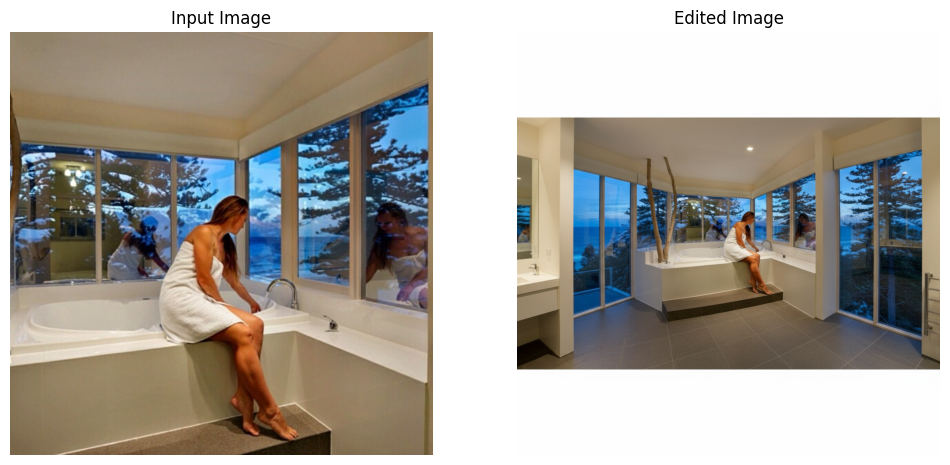

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(tmp)
plt.title("Input Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tmp1)
plt.title("Edited Image")
plt.axis('off')
plt.show()

In [61]:
# 找到 data_all 中 'output_image' 包含 'positive-edit/15.png' 的索引
indices = [i for i, d in enumerate(data_all) if 'positive-edit/15.png' in d.get('output_image', '')]
print("Matching indices:", indices)

Matching indices: [11]


In [117]:
edit_type_counts

Counter({'Add film grain or vintage filter': 15443,
         'Strong artistic style transfer (e.g., Van Gogh/anime/etc.)': 15284,
         'Remove an existing object': 15109,
         'Modern ↔ historical style/look': 14856,
         'Add new scene context/background': 14829,
         'Change overall color tone (warm ↔ cool)': 14745,
         'Replace one object category with another': 14547,
         'Add a new object to the scene': 14187,
         "Change an object's attribute (e.g., color/material)": 13813,
         'Zoom in': 13729,
         'Apply seasonal transformation (summer ↔ winter)': 13438,
         'Photo to cartoon/sketch/comic': 12735,
         'Adjust global lighting (golden hour/fluorescent)': 12432,
         'Outpainting (extend canvas beyond boundaries)': 12402,
         'Change weather conditions (sunny/rainy/snowy)': 11992,
         'Change the size/shape/orientation of an object': 10787,
         'Relocate an object (change its position/spatial relation)': 6612,
 

In [118]:
from collections import Counter

# 统计 data_all 中所有条目的 edit_type
edit_types = [d.get('edit_type') for d in data_all if 'edit_type' in d]
edit_type_counts = Counter(edit_types)
edit_type_all = []
print("Edit type counts:")
for edit_type, count in edit_type_counts.items():
    print(f"{edit_type}: {count}")
    edit_type_all.append(edit_type)

Edit type counts:
Remove an existing object: 15109
Change overall color tone (warm ↔ cool): 14745
Add new scene context/background: 14829
Replace one object category with another: 14547
Add a new object to the scene: 14187
Photo to cartoon/sketch/comic: 12735
Add film grain or vintage filter: 15443
Change the size/shape/orientation of an object: 10787
Outpainting (extend canvas beyond boundaries): 12402
Change an object's attribute (e.g., color/material): 13813
Change weather conditions (sunny/rainy/snowy): 11992
Strong artistic style transfer (e.g., Van Gogh/anime/etc.): 15284
Adjust global lighting (golden hour/fluorescent): 12432
Modern ↔ historical style/look: 14856
Apply seasonal transformation (summer ↔ winter): 13438
Relocate an object (change its position/spatial relation): 6612
Zoom in: 13729
Sticker-ify the person with bold outline and white border: 1422
Add/Remove/Replace Accessories (glasses, hats, jewelry, masks): 1597
Line-art ink sketch of the person: 1482
Funko-Pop–styl

In [307]:
etype = edit_type_all[35]

IndexError: list index out of range

Change font style or color of visible text if there is text
Skipping example: Input openimages/source/train_0/0008b6b7ad6dd351.jpg or Output openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/images/positive-edit/kewbam_retry2.png does not exist.
Skipping example: Input openimages/source/train_0/00068a9d975dcc8a.jpg or Output openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/images/positive-edit/kewaty_retry2.png does not exist.
Skipping example: Input openimages/source/train_0/000684f06733f2bd.jpg or Output openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/images/positive-edit/kewatz_retry1.png does not exist.
Skipping example: Input openimages/source/train_0/000412e8f4509c60.jpg or Output openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/openimages/edited/sft/images/positive-edit/303751.png does not exist.
Skipping example: Input openimages/source/train_0/0

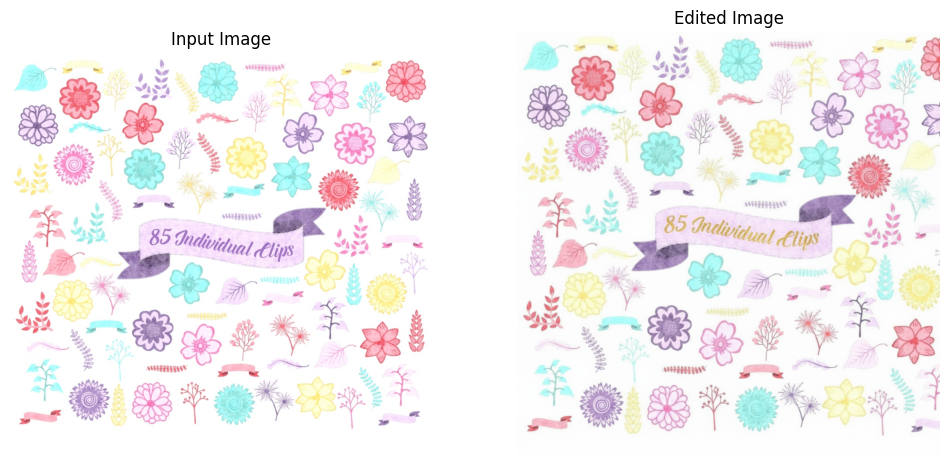

In [306]:

print(etype)
filtered_data = [d for d in data_all if d.get('edit_type') == etype]
i = 500
n = 0
if filtered_data:
    import os
    import PIL.Image as Image
    import matplotlib.pyplot as plt

    found = False
    for example in filtered_data:
        example['output_image'] = example['output_image'].replace('images/positive-edit','openimages/edited/sft/images/positive-edit')
        if os.path.exists(example["local_input_image"]) and os.path.exists(example["output_image"]):
            n+=1
            if n < i :
                pass
            print("Example data:")
            print(example)
            
            # 加载图像
            input_img = Image.open(example["local_input_image"])
            output_img = Image.open(example["output_image"])

            # 显示图像
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(output_img)
            plt.title("Edited Image")
            plt.axis('off')
            plt.show()
            found = True
            break
        else:
            print(f"Skipping example: Input {example['local_input_image']} or Output {example['output_image']} does not exist.")

    if not found:
        print("No valid example found with existing images.")
else:
    print("No data found for this edit_type")

In [ ]:
etype = edit_type_all[29]

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel

try:
    from scipy.ndimage import label as cc_label
except ImportError:
    cc_label = None

model_id = "facebook/dinov3-vit7b16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()


In [ ]:
input_img
output_img

In [19]:
import torch
features_tensor = torch.tensor(input_img_features[0])
print("Shape:", features_tensor.shape)
print("Sample:", features_tensor[:5, :10])

Shape: torch.Size([201, 4096])
Sample: tensor([[ 0.2559, -0.0442,  0.0928, -0.0913, -0.0996, -0.0082,  0.0272,  0.1206,
         -0.0066,  0.0095],
        [ 0.3516, -0.0223,  0.1147,  0.0264, -0.0139,  0.0415, -0.0398,  0.0752,
          0.0403, -0.1699],
        [-0.0225, -0.0182,  0.0182,  0.0298,  0.0050, -0.0070, -0.0432,  0.0047,
         -0.0179, -0.0105],
        [ 0.1128, -0.0308,  0.0400, -0.0144, -0.1021,  0.0596, -0.0664,  0.0121,
         -0.1099, -0.2432],
        [ 0.0371,  0.2041,  0.0442,  0.2324,  0.0045, -0.0618, -0.0129, -0.0762,
         -0.1270,  0.0439]])


In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 假设 input_img 和 output_img 已经加载（从之前的代码）
# input_img_features 和 output_img_features 已经提取

# 获取图像尺寸（假设 input_img 和 output_img 有相同尺寸）
H, W = input_img.size  # PIL Image.size 返回 (W, H)，但通常 H 是高度
# 注意：PIL Image.size 是 (width, height)，所以 W, H = input_img.size

# DINOv3 使用 16x16 patches
patch_size = 16
num_patches_h = H // patch_size
num_patches_w = W // patch_size

# 提取 patch features（假设 features 是 [1, num_patches, dim]）
input_patches = input_img_features[0]  # [num_patches, dim]
output_patches = output_img_features[0]  # [num_patches, dim]

# 计算 cosine similarity 矩阵：每个输入 patch 与所有输出 patch 的相似度
sim_matrix = F.cosine_similarity(input_patches.unsqueeze(1), output_patches.unsqueeze(0), dim=2)  # [num_input_patches, num_output_patches]

# 对于每个输入 patch，找到与输出 patch 的最大相似度
max_sim_per_input_patch = sim_matrix.max(dim=1)[0]  # [num_input_patches]

# 设置阈值（可调整，例如 0.8 表示高相似度）
threshold = 0.8
similar_mask_patches = (max_sim_per_input_patch > threshold).float()  # [num_patches]，1 为相似，0 为不相似

# 将 patch-level mask 重塑为 2D (num_patches_h, num_patches_w)
similar_mask_2d = similar_mask_patches.view(num_patches_h, num_patches_w)

# 上采样到原始图像尺寸
similar_mask_full = F.interpolate(similar_mask_2d.unsqueeze(0).unsqueeze(0), size=(H, W), mode='nearest').squeeze(0).squeeze(0)

# 转换为 numpy 用于绘图
similar_mask_np = similar_mask_full.cpu().numpy()

# 绘制结果
plt.figure(figsize=(15, 5))

# 输入图像
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis('off')

# 输出图像
plt.subplot(1, 3, 2)
plt.imshow(output_img)
plt.title("Output Image")
plt.axis('off')

# 相似区域 mask（使用热图显示相似度）
plt.subplot(1, 3, 3)
plt.imshow(similar_mask_np, cmap='hot', alpha=0.7)  # 热图，相似区域更亮
plt.imshow(input_img, alpha=0.3)  # 叠加输入图像以便对比
plt.title("Similarity Mask (Hot: Similar)")
plt.axis('off')

plt.show()

AttributeError: 'list' object has no attribute 'unsqueeze'